# Random Forest Classifier For Time Series

## Dependencies and Defaults

In [1]:
import subscript.config as cn
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import HTML
import pandas as pd
import numpy as np

## Read in the clean time series dataset

In [2]:
df = pd.read_csv(os.path.join(cn.clean_dir,'random_forest_time',
        'final_time_stats.csv'),dtype = 'unicode')
df = df.drop_duplicates()
df = df.fillna(0)
train_set = pd.read_csv(os.path.join(cn.clean_dir,'random_forest_time',
        'time_stratified_train.csv'))
train_set = train_set.drop_duplicates()
train_set = train_set.fillna(0)
test_set = pd.read_csv(os.path.join(cn.clean_dir,'random_forest_time',
        'time_stratified_test.csv'))


## Prepare training and test sets

In [3]:
test_set = test_set.drop_duplicates()
test_set = test_set.fillna(0)

y_train = train_set.engagement
X_train = train_set.drop('engagement',axis = 1)
y_test = test_set.engagement
X_test = test_set.drop('engagement',axis = 1)

print(X_train.shape, X_test.shape)

(112058, 75) (38216, 75)


## Fit the timeseries data

In [4]:
# Option for running the classifier without class weights
#selected = RandomForestClassifier(n_estimators = 200,n_jobs = -1,
#            oob_score = True,bootstrap = True,random_state = 17)


# Option for running the classifier with class weights
class_weight = dict({0:.9, 1:1.23, 2:5.46})
selected = RandomForestClassifier(bootstrap=True,
            class_weight=class_weight, n_estimators=300,
            oob_score=True,random_state=17)
selected.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.9, 1: 1.23, 2: 5.46},
                       n_estimators=300, oob_score=True, random_state=17)

## Make Predictions

In [5]:
predictions = selected.predict(X_test)
df_pred = pd.DataFrame(X_test)
df_pred['prediction'] = predictions
df_pred['actual'] = y_test
df_pred.to_csv(os.path.join(cn.clean_dir, 
        'random_forest_time','final_time_predictions_demo.csv'), 
        index = False)
df_pred.head()

,gear_score,2015-01,2016-01,2017-01,2018-01,2019-01,2020-01,2015-02,2016-02,2017-02,...,2018-11,2019-11,2014-12,2015-12,2016-12,2017-12,2018-12,2019-12,prediction,actual
0,478.0,8.0,6.0,8.0,11.0,25.0,45.0,8.0,7.0,4.0,...,17.0,9.0,5.0,6.0,5.0,22.0,14.0,26.0,0.0,0.0
1,427.0,4.0,1.0,1.0,1.0,1.0,6.0,1.0,2.0,0.0,...,2.0,5.0,4.0,5.0,1.0,1.0,1.0,2.0,0.0,0.0
2,475.0,10.0,13.0,1.0,2.0,1.0,0.0,0.0,6.0,1.0,...,2.0,1.0,27.0,10.0,0.0,1.0,5.0,0.0,0.0,0.0
3,435.0,1.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,...,16.0,6.0,2.0,2.0,0.0,1.0,4.0,20.0,0.0,0.0
4,405.0,0.0,3.0,8.0,2.0,14.0,0.0,2.0,0.0,0.0,...,3.0,0.0,4.0,1.0,7.0,0.0,2.0,1.0,1.0,1.0


## Get accuracy score

In [6]:
print(selected.score(X_train,y_train))

0.9997947491477628


## Get out of bag score

In [7]:
print('Oob score...')
print(selected.oob_score_)

Oob score...
0.8499259312141927


## Calculate the confusion matrix

In [8]:
cnf_matrix = metrics.confusion_matrix(y_test,predictions)
print(cnf_matrix)

[[25829   730     3]
 [ 3767  6356    23]
 [  442   487   579]]


## Print the precision, recall, and accuracy

In [9]:
met = metrics.classification_report(y_test, predictions, digits=3)
folder = os.path.join(cn.clean_dir, 'random_forest_time',)
f_name = 'metrics_time_balanced_metrics.csv'
print(met)

              precision    recall  f1-score   support

         0.0      0.860     0.972     0.913     26562
         1.0      0.839     0.626     0.717     10146
         2.0      0.957     0.384     0.548      1508

    accuracy                          0.857     38216
   macro avg      0.885     0.661     0.726     38216
weighted avg      0.858     0.857     0.846     38216



## Plot the confusion matriix

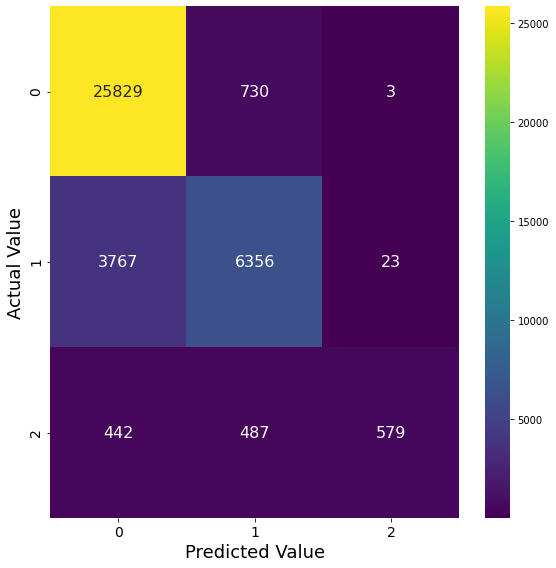

In [10]:
fig2, ax = plt.subplots(figsize = (8,8))
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'viridis', fmt = 'g', annot_kws={"size":16})
ax.set_xlabel ("Predicted Value", fontsize = 18)
ax.set_ylabel ("Actual Value", fontsize = 18)
ax.tick_params (labelsize = 14)
plt.tight_layout()
fig2.savefig(os.path.join(cn.clean_dir, 'random_forest_time','cnfmatrix_time_balanced.png'), dpi=180)

## Save the model

In [11]:
# save the model to disk
pickle_name = 'final_time_model.sav'
os.chdir(os.path.join(cn.clean_dir,'random_forest_time'))
with open(pickle_name, 'wb') as file:
    pickle.dump(selected, file)
plt.show()

## Get importances (years-months)

In [12]:
print("Important Features...")
importances = selected.feature_importances_
indices = np.argsort(importances)
important_features = X_train.columns.values[indices]
for i, v in enumerate(important_features[:25]):
    print(i,v)

Important Features...
0 2014-05
1 2014-07
2 2014-06
3 2014-04
4 2015-10
5 2016-03
6 2016-05
7 2014-09
8 2016-04
9 2014-08
10 2016-06
11 2015-04
12 2015-05
13 2016-02
14 2015-09
15 2017-03
16 2015-03
17 2017-02
18 2015-06
19 2015-08
20 2015-02
21 2016-01
22 2014-10
23 2015-11
24 2017-07


#### **Subscriber loyalty is the primary determinant of future engagement.**

This is very interesting because it suggests that players' multi-year history is more important than recent history in determining whether they will continue to be engaged with the content or lapse. The longer a subscriber plays, the more likely they are to continue playing, indicating a strong core player base. Going forward, there is significant business value in catering to loyal subscribers for greater long-term revenue. 